In [58]:
# Code source: Chad Leoanrd

import pandas as pd
import os 
import numpy as np
import seaborn as sns
import collections
from sklearn.pipeline import Pipeline
from sklearn import preprocessing, model_selection
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import csv
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier
from sklearn.decomposition import PCA
import missingno as msno
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier


import datetime as dt


%matplotlib inline 

In [2]:
def fix_num_cols(dframe, skiplist, dropcol=1):
    n = 0
    m = 0
    df_tmp = dframe.copy()
    for col in dframe.columns.values:
        if col not in skiplist:
            if isinstance(df_tmp[col].dtype,((object))):
                try:
                    df_tmp[col].fillna(df_tmp[col].median(), inplace=True)
                except:
                    if dropcol:
                        df_tmp.drop(col, inplace=True, axis=1)
                    else:
                        df_tmp[col].fillna('NUL', inplace=True)
    return df_tmp

In [3]:
def fix_data(df_, skip):
    catlist = []
    rest = []
    df_temp = df_.copy()
    
    # create 2 new lists: one for categorical data and the other for numerical
    with open('cols.csv', 'r') as csvfile:
        file = csv.reader(csvfile, delimiter=' ')
        for row in file:
            cl = row[0].split(",")[1].replace('"','').replace("'",'').replace('(','')
            if cl not in skip:
                tp = row[0].split(",")[0]
                if tp == 'cat':
                    catlist.append(cl)
                else:
                    rest.append(cl)
    # cat data turned into dummy variables and old cat column dropped
    df_cat = df_temp[catlist].copy()           
    for col in catlist:
        df_cat = pd.merge(df_cat, pd.get_dummies(df_cat[col].astype('category').cat.codes, prefix=col)\
                             ,left_index=True, right_index=True)
        df_cat.drop([col],inplace=True, axis=1)
        
    # continous numeric data scaled ... 
    scaler = preprocessing.StandardScaler()
    df_ = fix_num_cols(df_temp[rest],skip)
    scaler.fit(df_)
    df_new = pd.merge(pd.DataFrame(scaler.transform(df_), columns=rest), \
                      df_cat,left_index=True, right_index=True)
    df_new['price_cat'] = df_temp['price_cat']
    
    return (df_new, rest)


In [3]:
km_list = ['additional_education_km', 'basketball_km', 'big_church_km', 'big_market_km', 'big_road1_km', \
           'big_road2_km', 'bulvar_ring_km', 'bus_terminal_avto_km', 'catering_km', 'cemetery_km', \
           'church_synagogue_km', 'detention_facility_km', 'exhibition_km', 'fitness_km', 'green_zone_km', \
           'hospice_morgue_km', 'ice_rink_km', 'incineration_km', 'industrial_km', 'kindergarten_km', 'kremlin_km', \
           'market_shop_km', 'metro_km_avto', 'metro_km_walk', 'mkad_km', 'mosque_km', 'museum_km',\
           'nuclear_reactor_km', 'office_km', 'oil_chemistry_km', 'park_km', 'power_transmission_line_km',\
           'preschool_km', 'public_healthcare_km', 'public_transport_station_km', 'radiation_km', 'railroad_km', \
           'railroad_station_avto_km', 'railroad_station_walk_km', 'sadovoe_km', 'school_km', 'shopping_centers_km', \
           'stadium_km', 'swim_pool_km', 'theater_km', 'thermal_power_plant_km', 'ts_km', 'ttk_km', \
           'university_km', 'water_km', 'water_treatment_km', 'workplaces_km', 'zd_vokzaly_avto_km']
len(km_list)

53

In [4]:
if __name__ == "__main__":
    print (dt.datetime.now())
    skip = ['price_cat','id','timestamp','price_doc']
    dir_path = os.getcwd() + '/../../../data/all/'
    print (dir_path)
    df = pd.read_csv(dir_path + 'train.csv')
    df_macro = pd.read_csv(dir_path + 'macro.csv')

    df['price_length'] = [7.5 if cat > 6e6 and cat < 1e7 else len(str(cat)) for cat in df['price_doc'] ]    
    df['price_length'] = [l if l < 8 else 8 for l in df['price_length']]    
    df['price_cat'] = df['price_length'].astype('category').cat.codes    
    df['quarter'] = df['timestamp'].apply(lambda x: pd.Timestamp(x).quarter)
    
    df.loc[df.price_cat == 4, 'price_cat'] = 3
    print (dt.datetime.now())    

2018-11-25 14:12:01.439620
/Users/chadleonard/Springboard/work/springboard/capstone/projects/capstone1_Sberbank/../../../data/all/
2018-11-25 14:12:03.955319


In [5]:
df.shape

(30471, 295)

In [6]:
catlist = []
rest = []
with open('cols.csv', 'r') as csvfile:
    file = csv.reader(csvfile, delimiter=' ')
    for row in file:
        cl = row[0].split(",")[1].replace('"','').replace("'",'').replace('(','')
        if cl not in skip:
            tp = row[0].split(",")[0]
            if tp == 'cat':
                catlist.append(cl)
            else:
                rest.append(cl)
print(len(catlist))
print(len(rest))

68
336


In [8]:
newlist = []
for col in rest:
    if col in df.columns:
        newlist.append(col)
print(len(newlist))

250


In [8]:
print (dt.datetime.now())    
df_eda = pd.merge(df, df_macro, how='inner', on='timestamp', left_on=None, right_on=None,
     left_index=False, right_index=False, sort=True,
     suffixes=('_x', '_y'), copy=True, indicator=False,
     validate=None)

null_yr = 9999.0
yr = dt.datetime.now().year
# take care of bad dates, dates too old, too far out into the future, or NaN. Set them all to 9999.0
for i in df_eda['build_year'].index:
    if df_eda.loc[i, 'build_year'] < 1700 \
            or np.isnan(df_eda.loc[i, 'build_year']) \
            or df_eda.loc[i, 'build_year'] > yr:
        df_eda.loc[i, 'build_year'] = null_yr

df_eda.drop(['price_length','id', 'timestamp'], inplace=True, axis=1)
df_eda.loc[df_eda[df_eda['state'] == 33.0].index, 'state'] = 3.0
print (dt.datetime.now())    

2018-11-25 14:13:48.704869
2018-11-25 14:13:57.192795


In [18]:
df_eda['diff_sq'] = df_eda['full_sq'] - df_eda['kitch_sq']
df_eda['plus_sq'] = df_eda['full_sq'] + df_eda['life_sq'] 
df_eda['km_sum'] = df_eda[km_list].apply(lambda x: sum(x), axis=1)


In [11]:
ind0 = df[df['price_cat'] == 0].index
ind1 = df[df['price_cat'] == 1].index
ind2 = df[df['price_cat'] == 2].index
ind3 = df[df['price_cat'] == 3].index
print(len(ind0))
print(len(ind1))
print(len(ind2))
print(len(ind3))

233
13750
11678
4810


In [12]:
slist = ['full_sq','trc_sqm_5000',  'metro_min_avto', 'trc_sqm_2000'\
        , 'area_m','raion_popul','diff_sq', 'life_sq', 'plus_sq', 'km_sum']

In [13]:
df_tst = fix_num_cols(df_eda[slist],['price_cat'])
df_tst['price_cat'] = df_eda['price_cat'].copy()

for col in slist:
    print(col)
    print(np.corrcoef(df_tst.loc[:, col], df_tst.loc[:,'price_cat']))
    print(list(zip(mutual_info_classif(df_tst.loc[:,['price_cat',col]], \
                                       df_tst.loc[:,'price_cat']), ['price_cat',col])))

full_sq
[[1.         0.28547947]
 [0.28547947 1.        ]]
[(1.057990974235401, 'price_cat'), (0.20613615424193066, 'full_sq')]
trc_sqm_5000
[[1.         0.29201334]
 [0.29201334 1.        ]]
[(1.058187882771386, 'price_cat'), (0.1990637125439525, 'trc_sqm_5000')]
metro_min_avto
[[ 1.         -0.22972209]
 [-0.22972209  1.        ]]
[(1.0575807481187656, 'price_cat'), (0.1827027796438625, 'metro_min_avto')]
trc_sqm_2000
[[1.         0.16673561]
 [0.16673561 1.        ]]
[(1.0578104747440813, 'price_cat'), (0.17423163139986309, 'trc_sqm_2000')]
area_m
[[ 1.         -0.21789212]
 [-0.21789212  1.        ]]
[(1.0577284295207545, 'price_cat'), (0.1598995742369973, 'area_m')]
raion_popul
[[1.         0.23936253]
 [0.23936253 1.        ]]
[(1.057761247610085, 'price_cat'), (0.16515422082572173, 'raion_popul')]
diff_sq
[[1.         0.24319148]
 [0.24319148 1.        ]]
[(1.0578104747440813, 'price_cat'), (0.14059652240351905, 'diff_sq')]
life_sq
[[1.         0.12739177]
 [0.12739177 1.       

In [14]:
def make_list(grep_name, ignore_name='ignore'):
    count_list = []
    for col in df_eda.columns:
        if grep_name in col and ignore_name not in col:
            count_list.append(col)
            
    return count_list

In [15]:
cafe_sum_min_list = ['cafe_sum_500_min_price_avg', 'cafe_sum_1000_min_price_avg', 'cafe_sum_1500_min_price_avg', \
 'cafe_sum_2000_min_price_avg', 'cafe_sum_3000_min_price_avg', 'cafe_sum_5000_min_price_avg']
cafe_sum_max_list = ['cafe_sum_500_max_price_avg', 'cafe_sum_1000_max_price_avg', 'cafe_sum_1500_max_price_avg', '\
cafe_sum_2000_max_price_avg', 'cafe_sum_3000_max_price_avg', 'cafe_sum_5000_max_price_avg']
build_count_list = ['build_count_block', 'build_count_wood', 'build_count_frame', 'build_count_brick', \
 'build_count_monolith','build_count_panel', 'build_count_foam', 'build_count_slag', 'build_count_mix', \
 'build_count_before_1920','build_count_1921-1945', 'build_count_1946-1970', 'build_count_1971-1995',\
 'build_count_after_1995']
raion_build_list = ['raion_build_count_with_material_info', 'raion_build_count_with_builddate_info']
big_church_count_list = ['big_church_count_500', 'big_church_count_1000', 'big_church_count_1500',\
                         'big_church_count_2000', 'big_church_count_3000', 'big_church_count_5000']
cafe_count_list = make_list('cafe_count')
church_count_list = make_list('church_count', 'big_church')
leisure_count_list = make_list('leisure_count')
market_count_list = make_list('market_count')
office_count_list = make_list('office_count')
sport_count_list = make_list('sport_count')
trc_count_list = make_list('trc_count')
print(len(leisure_count_list))
print(len(office_count_list))
print(len(sport_count_list))
print(len(trc_count_list))

6
6
6
6


In [16]:
# feature engineering 
print (dt.datetime.now())

df_eda['cafe_sum_min_total'] = df_eda[cafe_sum_min_list].apply(lambda x: sum(x), axis=1)
df_eda['cafe_sum_max_total'] = df_eda[cafe_sum_max_list].apply(lambda x: sum(x), axis=1)    
df_eda['build_count_total'] = df_eda[build_count_list].apply(lambda x: sum(x), axis=1)
df_eda['raion_build_count_total'] = df_eda[raion_build_list].apply(lambda x: sum(x), axis=1)
df_eda['big_church_count_total'] = df_eda[big_church_count_list].apply(lambda x: sum(x), axis=1)
df_eda['cafe_count_total'] = df_eda[cafe_count_list].apply(lambda x: sum(x), axis=1)
df_eda['church_count_total'] = df_eda[church_count_list].apply(lambda x: sum(x), axis=1)
df_eda['leisure_count_total'] = df_eda[leisure_count_list].apply(lambda x: sum(x), axis=1)
df_eda['market_count_total'] = df_eda[market_count_list].apply(lambda x: sum(x), axis=1)
df_eda['office_count_total'] = df_eda[office_count_list].apply(lambda x: sum(x), axis=1)
df_eda['sport_count_total'] = df_eda[sport_count_list].apply(lambda x: sum(x), axis=1)
df_eda['trc_count_total'] = df_eda[trc_count_list].apply(lambda x: sum(x), axis=1)

df_train = fix_num_cols(df_eda,skip)

x_list = [col for col in list(df_train.columns) if col not in skip]

print (dt.datetime.now())

2018-11-25 14:18:59.504182
2018-11-25 14:19:08.723234


In [21]:
df_train['diff_sq'] = df_train['full_sq'] - df_train['kitch_sq']

In [26]:
df_log = df_train.loc[:,slist + ['price_cat']].copy()
df_log.head()

,full_sq,trc_sqm_5000,metro_min_avto,trc_sqm_2000,area_m,raion_popul,diff_sq,life_sq,plus_sq,km_sum,price_cat
0,43,4036616,2.590241,1244891,6.407578e+06,155572,37.0,27.0,70.0,263.886239,1
1,34,2034942,0.936700,179065,9.589337e+06,115352,28.0,19.0,53.0,171.319659,1
2,43,1572990,2.120999,52550,4.808270e+06,101708,37.0,29.0,72.0,157.314113,1
3,89,942180,1.489049,89492,1.258354e+07,178473,83.0,50.0,139.0,340.857760,3
4,77,3503058,1.257186,564843,8.398461e+06,108171,71.0,77.0,154.0,123.800872,3


In [27]:
with open('all_cols.csv', 'w') as f:
    writer = csv.writer(f)
    for col in sorted(x_list):
        #print(col)
        writer.writerow([col])

In [24]:
slist

['full_sq',
 'trc_sqm_5000',
 'metro_min_avto',
 'trc_sqm_2000',
 'area_m',
 'raion_popul',
 'diff_sq',
 'life_sq',
 'plus_sq',
 'km_sum']

In [8]:
# information gain
print (dt.datetime.now())
nlist = []
alist = ['full_sq','trc_sqm_5000', 'cafe_avg_price_5000', 'metro_min_avto', 'trc_sqm_2000'\
        ,'16_29_male', 'area_m','raion_popul','km_sum', 'diff_sq', 'plus_sq', 'cafe_sum_min_total' \
        ,'cafe_sum_max_total', 'build_count_total', 'raion_build_count_total', 'big_church_count_total'\
        ,'cafe_count_total', 'church_count_total', 'leisure_count_total', 'market_count_total', 'office_count_total'\
        ,'sport_count_total', 'trc_count_total']
for col in alist:
    for c in alist:
        v = str(col + ' <==> '+ c)
        t = np.cov(df_train[c], df_train[col])
        #print(v)
        #print(t[1][0])
        nlist.append((t[1][0],v))

print (dt.datetime.now())
#sorted(nlist,reverse=True)

2018-11-23 09:59:11.120210
2018-11-23 09:59:11.339842


In [31]:
#llist = alist
llist = slist

In [25]:
len(x_list)

386

In [28]:
# information gain
print (dt.datetime.now())
flist = []
for col in slist:
    res = list(zip(mutual_info_classif(df_log[['price_cat',col]], df_log['price_cat']), ['price_cat',col]))
    #print(sorted(res,reverse=True))
    flist.append(res[1])

print (dt.datetime.now())
sorted(flist,reverse=True)[:100]

2018-11-25 14:26:11.197425
2018-11-25 14:26:20.937027


[(0.2020699057291795, 'trc_sqm_5000'),
 (0.20093991533583266, 'full_sq'),
 (0.1958238302975237, 'km_sum'),
 (0.18228312773341093, 'metro_min_avto'),
 (0.177991536143997, 'trc_sqm_2000'),
 (0.1775910750679892, 'plus_sq'),
 (0.17434816381873208, 'diff_sq'),
 (0.16356533178026167, 'raion_popul'),
 (0.15685028258338862, 'area_m'),
 (0.1351067156179857, 'life_sq')]

In [32]:
df_log['price_cat_test1'] = pd.Series([1 if cd == 1 else 0 for cd in df_log['price_cat']], index=df_log.index)
df_log.head()

,full_sq,trc_sqm_5000,metro_min_avto,trc_sqm_2000,area_m,raion_popul,diff_sq,life_sq,plus_sq,km_sum,price_cat,price_cat_test1
0,43,4036616,2.590241,1244891,6.407578e+06,155572,37.0,27.0,70.0,263.886239,1,1
1,34,2034942,0.936700,179065,9.589337e+06,115352,28.0,19.0,53.0,171.319659,1,1
2,43,1572990,2.120999,52550,4.808270e+06,101708,37.0,29.0,72.0,157.314113,1,1
3,89,942180,1.489049,89492,1.258354e+07,178473,83.0,50.0,139.0,340.857760,3,0
4,77,3503058,1.257186,564843,8.398461e+06,108171,71.0,77.0,154.0,123.800872,3,0


In [60]:
df_log['price_cat_test2'] = pd.Series([1 if cd == 2 else 0 for cd in df_log['price_cat']], index=df_log.index)
df_log.head()

,full_sq,trc_sqm_5000,metro_min_avto,trc_sqm_2000,area_m,raion_popul,diff_sq,life_sq,plus_sq,km_sum,price_cat,price_cat_test1,price_cat_test2
0,43,4036616,2.590241,1244891,6.407578e+06,155572,37.0,27.0,70.0,263.886239,1,1,0
1,34,2034942,0.936700,179065,9.589337e+06,115352,28.0,19.0,53.0,171.319659,1,1,0
2,43,1572990,2.120999,52550,4.808270e+06,101708,37.0,29.0,72.0,157.314113,1,1,0
3,89,942180,1.489049,89492,1.258354e+07,178473,83.0,50.0,139.0,340.857760,3,0,0
4,77,3503058,1.257186,564843,8.398461e+06,108171,71.0,77.0,154.0,123.800872,3,0,0


In [61]:
df_log['price_cat_test2'].value_counts()

0    18793
1    11678
Name: price_cat_test2, dtype: int64

In [62]:
col = 'price_cat_test1'
#x_list = ig_list
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_log.loc[:, slist], \
                                                                df_log.loc[:, col], test_size=0.3)
X_train.shape

(21329, 10)

In [62]:
col = 'price_cat'
#x_list = ig_list
X_train_f, X_test_f, y_train_f, y_test_f = model_selection.train_test_split(df_log.loc[:, slist], \
                                                                df_log.loc[:, col], test_size=0.3)
X_train_f.shape

(21329, 10)

In [50]:
X_test.shape

(9142, 10)

In [63]:
print (dt.datetime.now())
h = .02  # step size in the mesh

#solver : str, {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, 
names = ["LogReg: newton-cg "
        ]

classifiers = [
    LogisticRegression(random_state=0, solver='newton-cg',multi_class='ovr'),
    ]
clf.fit(X_train, y_train)

model = RandomForestClassifier(max_depth=10, n_estimators=100)
#MLPClassifier(alpha=1,hidden_layer_sizes=(100,100,)),
#MLPClassifier(alpha=1,hidden_layer_sizes=(100,100,), solver='lbfgs'),
#MLPClassifier(alpha=1,hidden_layer_sizes=(100,100,), activation='tanh'),

X_train['test_score_proba'] = [p[0] for p in clf.predict_proba(X_train)]
X_test['test_score_proba'] = [p[0] for p in clf.predict_proba(X_test)]
y_train = df_log.loc[X_train.index, 'price_cat']
y_test = df_log.loc[X_test.index, 'price_cat']
model.fit(X_train,y_train)

print("train score: ", model.score(X_train,y_train))
print("test score: ", model.score(X_test,y_test))

#plt.tight_layout()
#plt.show()

2018-11-25 15:17:40.493572
train score:  0.8062731492334381
test score:  0.7700721942682126


In [ ]:
col = 'price_cat'
#x_list = ig_list
X_train_f, X_test_f, y_train_f, y_test_f = model_selection.train_test_split(df_log.loc[:, slist], \
                                                                df_log.loc[:, col], test_size=0.3)
X_train_f.shape

In [64]:
print (dt.datetime.now())
h = .02  # step size in the mesh

names = ["Nearest Neighbors",  
         "Extra Tree Clf",
         "Gradient Boost Clf",
         "Ridge Classifier",
         "Decision Tree", 
         "Random Forest", 
         "Neural Net: adam",
         "Neural N: lbfgs",
         "Neural Net: tanh"        ]

classifiers = [
    KNeighborsClassifier(7),
    ExtraTreesClassifier(n_estimators=100),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=5, random_state=0),
    RidgeClassifier(),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=100),
    MLPClassifier(alpha=1,hidden_layer_sizes=(100,100,)),
    MLPClassifier(alpha=1,hidden_layer_sizes=(100,100,), solver='lbfgs'),
    MLPClassifier(alpha=1,hidden_layer_sizes=(100,100,), activation='tanh'),
    ]

score_dict = dict()
score_list = []
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print(name)
    print("train score: ", clf.score(X_train,y_train))
    train_score = clf.score(X_train,y_train)
    test_score = clf.score(X_test, y_test)
    print("test score: ", str(test_score))
    score_dict.update({test_score: (name, train_score)})
    print (dt.datetime.now())
    print('='*10)


od = collections.OrderedDict(sorted(score_dict.items(),reverse=True))    

print (dt.datetime.now())
print(slist)
od

2018-11-25 15:18:09.315366
Nearest Neighbors
train score:  0.7389469736040133
test score:  0.6368409538394224
2018-11-25 15:18:09.904820
Extra Tree Clf
train score:  0.9864034882085424
test score:  0.7656967840735069
2018-11-25 15:18:13.525477
Gradient Boost Clf
train score:  0.799803085001641
test score:  0.6761102603369066
2018-11-25 15:18:24.738097
Ridge Classifier
train score:  0.6139997186928595
test score:  0.607197549770291
2018-11-25 15:18:24.839262
Decision Tree
train score:  0.7935205588635191


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.730101e-18
  overwrite_a=True).T


test score:  0.7456792824327281
2018-11-25 15:18:24.942278
Random Forest
train score:  0.8052885742416428
test score:  0.7700721942682126
2018-11-25 15:18:27.711286
Neural Net: adam
train score:  0.4005344835669745
test score:  0.4070225333625027
2018-11-25 15:18:28.995513
Neural N: lbfgs
train score:  0.15120258802569272
test score:  0.1618901772041129
2018-11-25 15:18:31.001690
Neural Net: tanh
train score:  0.49355337802991234
test score:  0.4922336469043973
2018-11-25 15:18:35.470508
2018-11-25 15:18:35.470724
['full_sq', 'trc_sqm_5000', 'metro_min_avto', 'trc_sqm_2000', 'area_m', 'raion_popul', 'diff_sq', 'life_sq', 'plus_sq', 'km_sum']


OrderedDict([(0.7700721942682126, ('Random Forest', 0.8052885742416428)),
             (0.7656967840735069, ('Extra Tree Clf', 0.9864034882085424)),
             (0.7456792824327281, ('Decision Tree', 0.7935205588635191)),
             (0.6761102603369066, ('Gradient Boost Clf', 0.799803085001641)),
             (0.6368409538394224, ('Nearest Neighbors', 0.7389469736040133)),
             (0.607197549770291, ('Ridge Classifier', 0.6139997186928595)),
             (0.4922336469043973, ('Neural Net: tanh', 0.49355337802991234)),
             (0.4070225333625027, ('Neural Net: adam', 0.4005344835669745)),
             (0.1618901772041129, ('Neural N: lbfgs', 0.15120258802569272))])

In [40]:
test_score_proba[0]

array([0.52984921, 0.47015079])

In [37]:
selector=SelectKBest(score_func=f_classif,k='all')
selector.fit(X_train,y_train)
#print("scores_:",selector.scores_)
#print("pvalues_:",selector.pvalues_)
#print("selected index:",selector.get_support(True))
X_train = pd.DataFrame(selector.transform(X_train))
#X_test = selector.transform(X_test)
print("after transform:",X_train) 

after transform:            0          1          2          3             4         5      6
0       36.0   396866.0   1.113451    81104.0  8.889467e+06   90114.0   44.0
1       76.0  1946680.0   5.309669    13626.0  9.629358e+06   89467.0   44.0
2       56.0   835272.0   1.131661    60634.0  1.504557e+07  102828.0   51.0
3       48.0    17000.0   9.984238        0.0  2.553630e+07    4001.0   47.0
4       30.0  1722066.0   2.364080   367091.0  4.787424e+06   96959.0   24.0
5       42.0  1137771.0   2.338630    27000.0  8.659075e+06  104410.0   44.0
6       39.0  1061263.0   1.584286   650124.0  1.675112e+07  155427.0   44.0
7       30.0  1530115.0   3.004164   727003.0  6.879020e+06  112221.0   44.0
8       38.0  1060726.0   3.594263   231496.0  8.392316e+06  130396.0   28.0
9       43.0   262000.0   3.121542        0.0  2.149409e+07    7122.0   44.0
10      51.0   768507.0   1.564507   115788.0  1.504557e+07  102828.0   44.0
11      43.0  1725130.0   2.226595   427100.0  6.206099e+06

In [79]:
# od = collections.OrderedDict(sorted(dict(zip(selector.scores_, x_list)).items(),reverse=True))
od = collections.OrderedDict(sorted(score_dict.items(),reverse=True))
od

OrderedDict([(0.791316208229143, 'Random Forest'),
             (0.7892702887019777, 'Neural Net: lbfgs'),
             (0.7865423959990907, 'Extra Tree Classifier'),
             (0.7654012275517162, 'Decision Tree'),
             (0.7558536030916118, 'Nearest Neighbors'),
             (0.7538076835644465, 'Neural Net: adam'),
             (0.7460786542396, 'Gradient Boosting Classifier'),
             (0.7331211639008866, 'Neural Net: tanh'),
             (0.7092521027506251, 'Linear SVM'),
             (0.696521936803819, 'Logistic Regression Multinomial'),
             (0.6803819049784042, 'AdaBoost'),
             (0.6333257558536031, 'Ridge Classifier'),
             (0.6030916117299386, 'Stochastic Gradient Descent')])

In [116]:
print (dt.datetime.now())
pca = PCA(n_components=2)# adjust yourself
pca.fit(X_train)
X_t_train = pca.transform(X_train)
X_t_test = pca.transform(X_test)
X_train['pca1'] = pd.Series(X_t_train[:,0], index=X_train.index)
X_train['pca2'] = pd.Series(X_t_train[:,1], index=X_train.index)
X_test['pca1'] = pd.Series(X_t_test[:,0], index=X_test.index)
X_test['pca2'] = pd.Series(X_t_test[:,1], index=X_test.index)

clf = MLPClassifier(alpha=1,hidden_layer_sizes=(100,100,))
clf.fit(X_train[llist + ['pca1', 'pca2']], y_train)
print ('train score', clf.score(X_train[llist + ['pca1', 'pca2']], y_train))
print ('test score', clf.score(X_test[llist + ['pca1', 'pca2']], y_test))
print ('pred label', clf.predict(X_test[llist + ['pca1', 'pca2']]))
print (dt.datetime.now())

2018-11-21 21:34:50.696204
train score 0.7965705378020265
test score 0.7933621277563082
pred label [3 3 2 ... 2 3 3]
2018-11-21 21:34:56.825105


In [122]:
print (dt.datetime.now())
pca = PCA(n_components=4)# adjust yourself
pca.fit(X_train)
X_t_train = pca.transform(X_train)
X_t_test = pca.transform(X_test)
X_train['pca1'] = pd.Series(X_t_train[:,0], index=X_train.index)
X_train['pca2'] = pd.Series(X_t_train[:,1], index=X_train.index)
X_train['pca3'] = pd.Series(X_t_train[:,2], index=X_train.index)
X_train['pca4'] = pd.Series(X_t_train[:,3], index=X_train.index)
X_test['pca1'] = pd.Series(X_t_test[:,0], index=X_test.index)
X_test['pca2'] = pd.Series(X_t_test[:,1], index=X_test.index)
X_test['pca3'] = pd.Series(X_t_test[:,2], index=X_test.index)
X_test['pca4'] = pd.Series(X_t_test[:,3], index=X_test.index)

clf = RandomForestClassifier(criterion='entropy', n_estimators=500)
clf.fit(X_train, y_train)
print ('train score', clf.score(X_train, y_train))
print ('test score', clf.score(X_test, y_test))
print ('pred label', clf.predict(X_test))
print (dt.datetime.now())

2018-11-21 21:40:46.028874
train score 1.0
test score 0.7744942032280063
pred label [3 2 3 ... 1 2 1]
2018-11-21 21:41:31.654223


In [112]:
print(X_t_train.shape)
print(X_train.shape)
X_train['pca1'] = pd.Series(X_t_train[:,0], index=X_train.index)
X_train['pca2'] = pd.Series(X_t_train[:,1], index=X_train.index)
X_train.head()

(10264, 2)
(10264, 1344)


,additional_education_km,apartment_build,area_m,average_provision_of_build_contract,average_provision_of_build_contract_moscow,balance_trade,balance_trade_growth,basketball_km,baths_share,big_church_km,...,ID_railroad_station_avto_125,ID_railroad_station_avto_126,ID_railroad_station_avto_127,ID_railroad_station_avto_128,ID_railroad_station_avto_129,ID_railroad_station_avto_130,ID_railroad_station_avto_131,ID_railroad_station_avto_132,pca1,pca2
19741,-0.603766,0.285407,0.018373,0.514518,-0.796481,1.026054,1.354684,-0.692734,-0.15918,-0.127809,...,0,0,0,0,0,0,0,0,-0.533318,-2.710021
5865,1.509271,0.359691,2.378554,-1.028282,-1.538939,0.698363,-0.789917,0.193925,-0.15918,0.612701,...,0,0,0,0,0,0,0,0,2.497065,0.179142
5897,-0.680836,0.359691,-0.695663,-1.028282,-1.538939,0.698363,-0.789917,-0.698257,-0.15918,-0.311110,...,0,0,0,0,0,0,0,0,-0.405151,0.904009
24576,1.157144,0.285407,2.378554,1.708945,0.890924,-0.391055,-0.838905,0.346047,-0.15918,0.584331,...,0,0,0,0,0,0,0,0,2.517122,-1.158595
27974,0.163022,0.285407,-0.345711,1.061964,0.587191,-0.247201,2.895095,-0.791540,-0.15918,-0.220482,...,0,0,0,0,0,0,0,0,-0.253964,0.702686


In [89]:
print (dt.datetime.now())
pca = PCA(n_components=2)# adjust yourself
pca.fit(X_train[llist])
X_t_train = pca.transform(X_train[llist])
X_t_test = pca.transform(X_test[llist])
clf = XGBClassifier(objective='multi:softmax', n_estimators=500)
clf.fit(X_t_train, y_train)
print ('score', clf.score(X_t_test, y_test))
print ('pred label', clf.predict(X_t_test))
print (dt.datetime.now())

2018-11-21 21:08:02.431628


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


score 0.7128892930211411
pred label [3 3 2 ... 2 3 3]
2018-11-21 21:08:08.589426


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [377]:
col = 'full_sq'
iz = df_train.loc[df_train[col] > 3, col].index
iy = df_train.loc[df_train[col] < -3, col].index
df_train.loc[iz, col] = 3.0
df_train.loc[iy, col] = -3.0

In [379]:
print (dt.datetime.now())
pca = PCA(n_components=2)# adjust yourself
pca.fit(X_train)
X_t_train = pca.transform(X_train)
X_t_test = pca.transform(X_test)
X_train['pca1'] = pd.Series(X_t_train[:,0], index=X_train.index)
X_train['pca2'] = pd.Series(X_t_train[:,1], index=X_train.index)
X_test['pca1'] = pd.Series(X_t_test[:,0], index=X_test.index)
X_test['pca2'] = pd.Series(X_t_test[:,1], index=X_test.index)

clf = MLPClassifier(alpha=1,hidden_layer_sizes=(100,100,))
clf.fit(X_train[llist + ['pca1', 'pca2']], y_train)
print ('train score', clf.score(X_train[llist + ['pca1', 'pca2']], y_train))
print ('test score', clf.score(X_test[llist + ['pca1', 'pca2']], y_test))
print ('pred label', clf.predict(X_test[llist + ['pca1', 'pca2']]))
print (dt.datetime.now())

2018-11-22 15:48:22.205515
train score 0.7901402961808262
test score 0.7804046374175949
pred label [3 2 1 ... 1 3 2]
2018-11-22 15:48:28.688381


In [391]:
X_train['price_cat'] = y_train.copy()

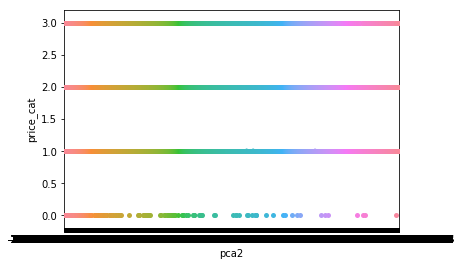

In [396]:
sns.stripplot(x=col, y="price_cat", data=X_train)

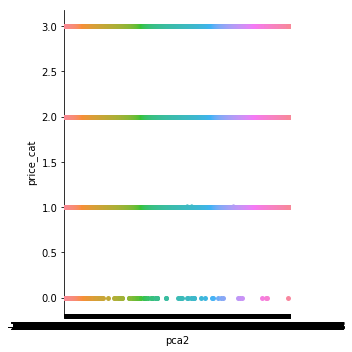

In [395]:
sns.catplot(x=col, y="price_cat", data=X_train);

In [412]:
hi_out_indx = X_train[(X_train['pca1'] > -10) & (X_train['pca1'] < 7.6)].index
len(hi_out_indx)

9276

In [420]:
idx3 = list(X_train[(X_train['pca1'] > -6) & (X_train['pca1'] < 6) & (X_train['price_cat'] == 3)].index)
idx2 = list(X_train[(X_train['pca1'] > -10) & (X_train['pca1'] < 6) & (X_train['price_cat'] == 2)].index)
idx1 = list(X_train[(X_train['pca1'] > -10) & (X_train['pca1'] < 7.6) & (X_train['price_cat'] == 1)].index)
idx0 = list(X_train[(X_train['pca1'] > -7.6) & (X_train['pca1'] < 3) & (X_train['price_cat'] == 0)].index)

idxlist = idx0 + idx1 + idx2 + idx3
len(idxlist)

9123

In [401]:
X_train.shape

(10264, 1357)

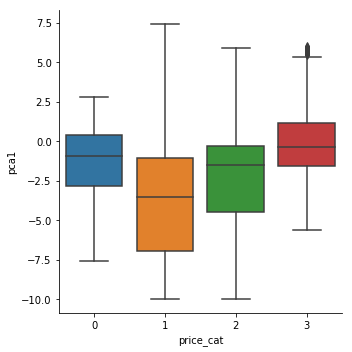

In [421]:
col='pca1'
sns.catplot(x="price_cat", y=col, kind="box", data=X_train.loc[idxlist][['price_cat','pca1']])

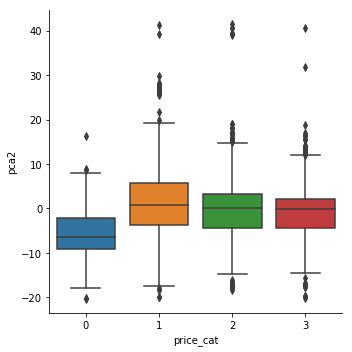

In [393]:
col='pca2'
sns.catplot(x="price_cat", y=col, kind="box", data=X_train)

In [47]:
sns.catplot(x="price_cat", y=col, kind="box", data=df_train[['price_cat',col]])

NameError: name 'df_train' is not defined

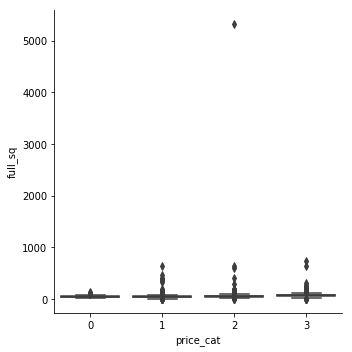

In [46]:
sns.catplot(x="price_cat", y='full_sq', kind="box", data=df[['price_cat','full_sq']])

/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


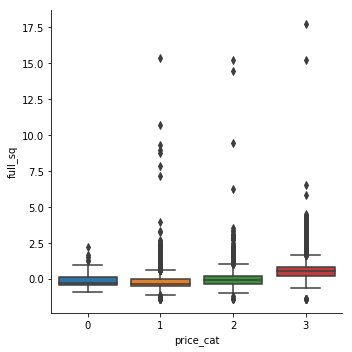

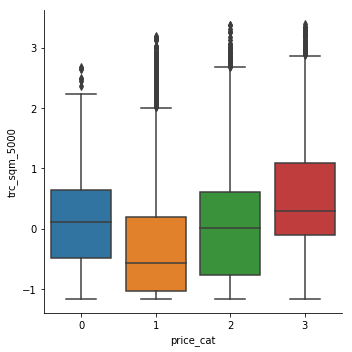

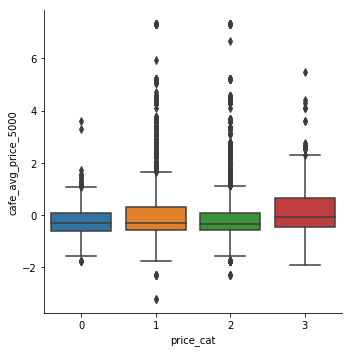

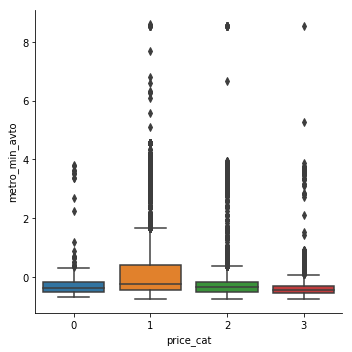

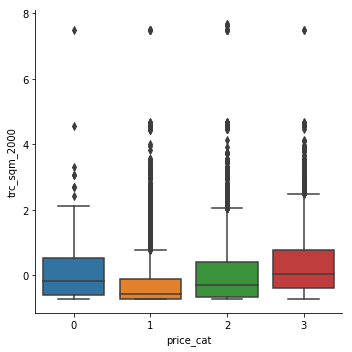

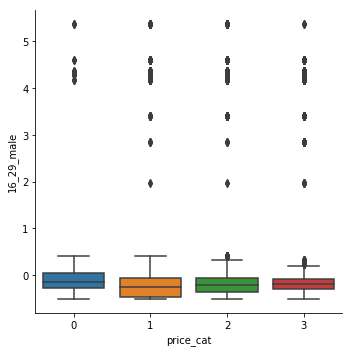

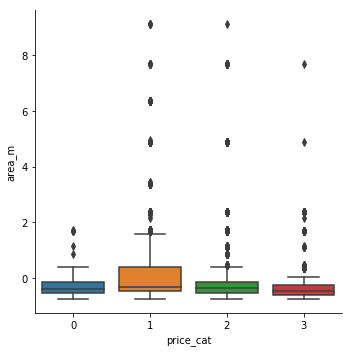

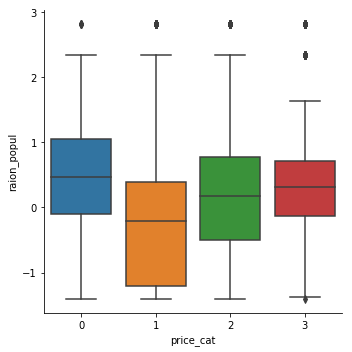

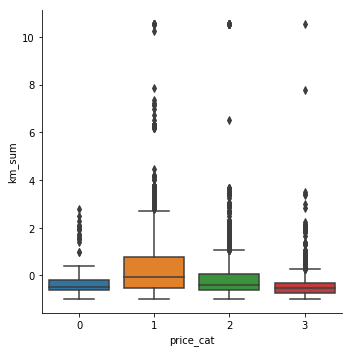

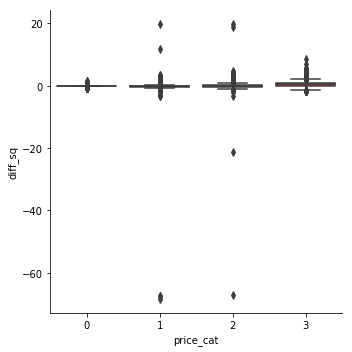

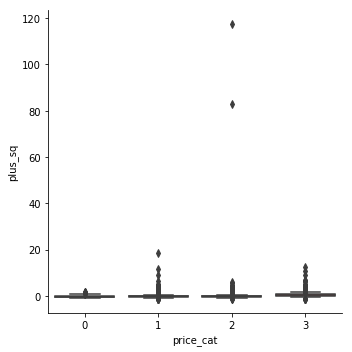

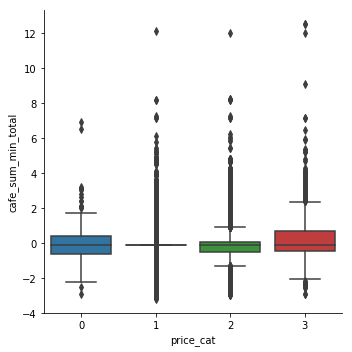

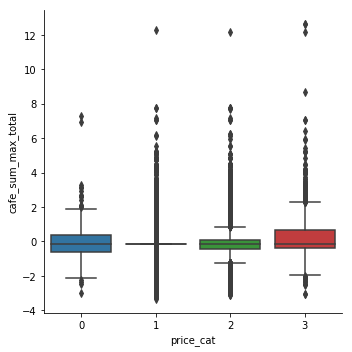

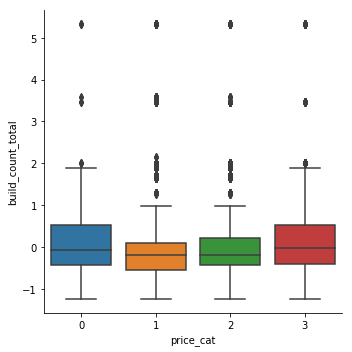

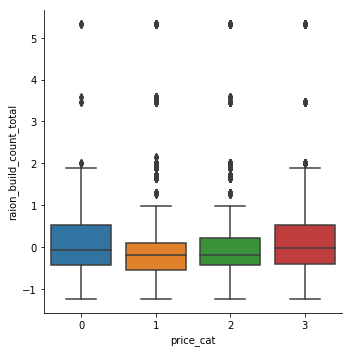

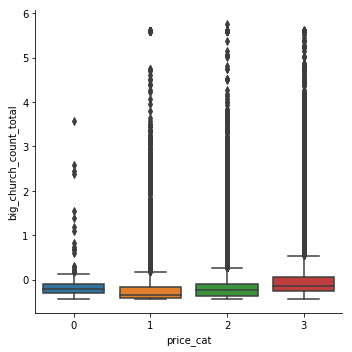

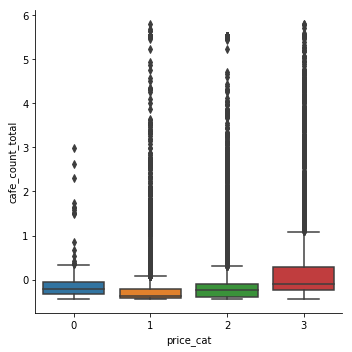

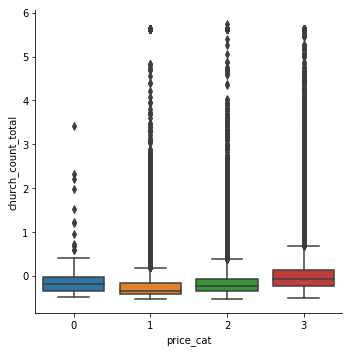

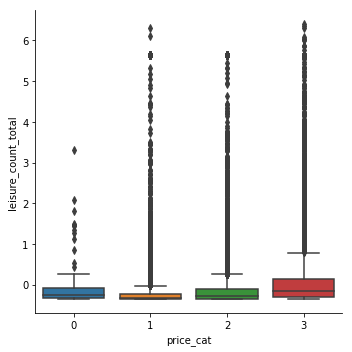

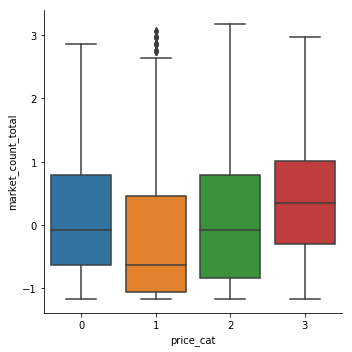

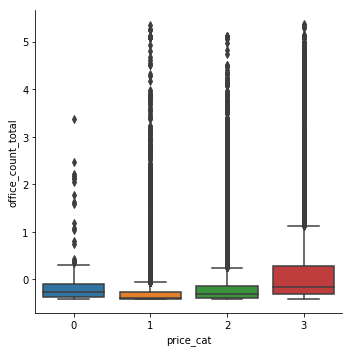

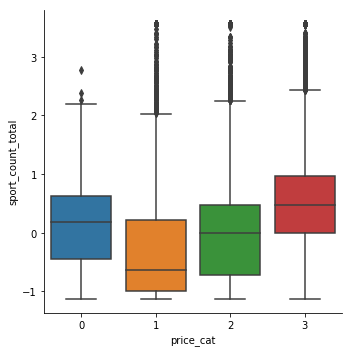

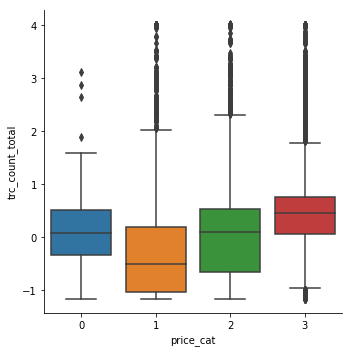

In [376]:
sk = ['timestamp', 'price_cat','price_doc']
for col in llist:
    if col not in sk:
        sns.catplot(x="price_cat", y=col, kind="box", data=df_train[['price_cat',col]])